# Ephaptic Coupling model analysis

Some experiments to (better) understand the model

In [7]:
import mean_field_model
import matplotlib.pyplot as plt
from scipy import signal, special

In [8]:
from matplotlib import rcParams
rcParams.update({
    'font.family': 'serif',
})

In [9]:
# %load mean_field_model.py
import attr
import numpy as np

# SI base units
s = 1
kg = 1
m = 1
A = 1

# derived units
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

# with prefixes
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
uV = 1e-6 * V
pF = 1e-12 * F
ms = 1e-3 * s
nA = 1e-9 * A
pA = 1e-12 * A


def kuhn_transfer_function(threshold, tau_eff, mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
                                 (np.sqrt(2) * np.sqrt(sigma_sq_u))))


def derivative_kuhn_transfer_function(threshold, tau_eff,  mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff * (np.sqrt(2 * sigma_sq_u)) * (2/ np.sqrt(np.pi)) *
                 np.exp(-(threshold - mu_u) ** 2 / (2 * sigma_sq_u)))


@attr.s
class EIMeanField:
    E_e = attr.ib(0 * mV)
    E_i = attr.ib(-75 * mV)
    E_l = attr.ib(-70 * mV)
    g_l = attr.ib(1./60 * uS)
    C = attr.ib(250 * pF)
    v_reset = attr.ib(-60 * mV)
    threshold = attr.ib(-50 * mV)
    threshold_inh = attr.ib(-53 * mV)
    tau_ref = attr.ib(2 * ms)
    T_e = attr.ib(0.2 * ms)  # width of excitatory PSC (ms)
    T_i = attr.ib(2 * ms)    # width of inhibitory PSC (ms)
    tau_e = attr.ib(1 * ms)  # timescale of excitatory population (ms)
    tau_i = attr.ib(0.5 * ms)    # timescale of inhibitory population (ms)
    B_e = attr.ib(7.1 * nS)    # peak excitatory conductance (nS)
    B_i = attr.ib(3.7 * nS)    # peak inhibitory conductance (nS)

    f_ext = attr.ib(5000 * Hz) # etracellular_firing_rate

    n_e = attr.ib(350.) # number of excitatory neurons
    n_i = attr.ib(350. / 4.) # number of inhibitory neurons

    noise_std_e = attr.ib(2000 * Hz / np.sqrt(s))
    noise_std_i = attr.ib(0 * Hz / np.sqrt(s))

    tau_adapt = attr.ib(800 * ms) # adaptation time constant
    beta_adapt = attr.ib(0.00005*mV / Hz) # strength of adaptation (per firing rate of E population)

    def calc_membrane_stats(self, fr_e, fr_i):

        mu_ge = fr_e * self.B_e * self.T_e * np.exp(1)
        mu_gi = fr_i * self.B_i * self.T_i * np.exp(1)

        gtot = self.g_l + mu_ge + mu_gi

        mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot

        tau_eff = self.C / gtot

        epsp_int = (self.E_e - mu_u) * self.B_e * self.T_e * np.exp(1) * tau_eff / self.C
        ipsp_int = (self.E_i - mu_u) * (self.B_i * self.T_i * np.exp(1) * tau_eff / self.C)
        epsp_sq =  epsp_int ** 2 * (2 * tau_eff + self.T_e) /(4 * (tau_eff + self.T_e)**2)
        ipsp_sq =  ipsp_int ** 2 * (2 * tau_eff + self.T_i) /(4 * (tau_eff + self.T_i)**2)
        sigma_sq_u = fr_e * epsp_sq + fr_i * ipsp_sq

        return gtot, mu_u, tau_eff, sigma_sq_u


    def calc_output_rate_inh_exc(self, fr_e, fr_i, delta_v_e=0, delta_v_i=0):
        gtot_exc, mu_u_exc, tau_eff_exc, sigma_sq_u_exc = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)
        gtot_inh, mu_u_inh, tau_eff_inh, sigma_sq_u_inh = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)

        rexc = kuhn_transfer_function(self.threshold + delta_v_e, tau_eff_exc, mu_u_exc, sigma_sq_u_exc)
        rinh = kuhn_transfer_function(self.threshold_inh + delta_v_i, tau_eff_inh, mu_u_inh, sigma_sq_u_inh)

        return rexc * self.n_e, rinh * self.n_i

    def ode_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        fexc, finh = self.calc_output_rate_inh_exc(rexc + self.f_ext,
                              rinh, theta_adapt + dv_e, dv_i)
        theta_adapt = theta_adapt + ((-theta_adapt +
                 self.beta_adapt * rexc) *
                 dt / self.tau_adapt)
        rinh = rinh + (-rinh + finh) * dt / self.tau_i
        rexc = rexc + (-rexc + fexc) * dt / self.tau_e


        return rexc, rinh, theta_adapt

    def sde_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        rexc, rinh, theta_adapt = self.ode_step(dt, rexc, rinh, theta_adapt, dv_e, dv_i)
        rexc += np.random.randn() * self.noise_std_e * np.sqrt(dt)
        rinh += np.random.randn() * self.noise_std_i * np.sqrt(dt)
        rexc = np.maximum(rexc, 0)
        rinh = np.maximum(rinh, 0)

        return rexc, rinh, theta_adapt

### 1.Running the model

In [10]:
# parameters and init
tau_adapt = 800 * ms # adaptation time constant
beta_adapt = 0.00005*mV / Hz # strength of adaptation (per firing rate of E population)
dt = 1. * ms # integration time step
tau_e = 10*ms # time constant of excitatory population
tau_i = 5* ms # time constant of inhibitory population
threshold_inh0 = -51 * mV # inhibitory threshold
noise_e = 2000 * Hz / s 
tmax = 20 * s
f_ext = 1000 * Hz

model = EIMeanField(tau_adapt=tau_adapt,
                    beta_adapt=beta_adapt,
                    tau_e=tau_e,
                    tau_i=tau_i,
                    threshold_inh=threshold_inh0,
                    noise_std_e=noise_e,
                    noise_std_i=0,
                    f_ext=f_ext
                    )

In [11]:
# running simulation
np.random.seed(100)
rexc = 100 * Hz
rinh = 100 * Hz
theta_adapt = 0 * mV
gamma = 0 * uV # in theory V/m
dt = 1*ms
t = 0
solution = []
while t < tmax:
    rexc, rinh, theta_adapt = model.sde_step(dt, rexc, rinh, theta_adapt, gamma)
    t += dt
    solution.append((rexc, rinh, theta_adapt))
solution = np.array(solution)
time = np.arange(solution.shape[0]) * dt

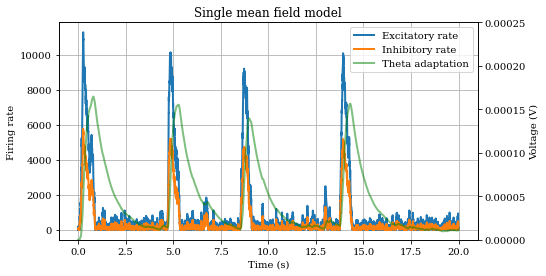

In [12]:
# plot
def plot_single(time, solution):
    fig, ax = plt.subplots(figsize=(7.5,4))
    l1 = ax.plot(time, solution[:,0], label="Excitatory rate", lw=2.0)[0]
    l2 = ax.plot(time, solution[:,1], label="Inhibitory rate", lw=2.0)[0]

    ax2 = ax.twinx()
    ax2.set_ylim([0.0,0.00025])
    l3 = ax2.plot(time, solution[:,2], label="Theta adaptation", lw=2.0,alpha=0.5, c='green')[0]

    lines = [l1,l2,l3]

    ax.legend(lines, [l.get_label() for l in lines])
    ax.set(title=f"Single mean field model",
           xlabel="Time (s)",
           ylabel="Firing rate")
    ax2.set(ylabel="Voltage (V)")
    ax.grid()

    fig.show()
    
plot_single(time, solution)

### 2.Single population with exogenous current (simple gamma addition)

In [13]:
# parameters and init
model_params = {
'tau_adapt': 800 * ms, # adaptation time constant
'beta_adapt': 0.00005*mV / Hz, # strength of adaptation (per firing rate of E population)
'tau_e': 10*ms, # time constant of excitatory population
'tau_i': 5* ms, # time constant of inhibitory population
'threshold_inh': -51 * mV, # inhibitory threshold
'noise_std_e': 2000 * Hz / s, 
'noise_std_i': 0,
'f_ext': 1000 * Hz,
}

model = EIMeanField(**model_params)

In [14]:
# running simulation
simulation_params = {
    'seed': 100,
    'rexc': 100*Hz,
    'rinh': 100*Hz,
    'theta_adapt': 0*mV,
    'gamma': 0*uV,
    'dt': 1*ms,
    'tmax': 20*s,
} 

def run_single(model, seed=100, rexc_i=100*Hz, rinh_i=100*Hz, theta_i=0*mV, gamma=0*uV, dt=1*ms, tmax=20*s):
    np.random.seed(100)
    
    rexc = rexc_i
    rinh = rinh_i
    theta = theta_i
    
    t = 0
    solution = []
    while t < tmax:
        rexc, rinh, theta = model.sde_step(dt, rexc, rinh, theta, gamma)
        t += dt
        solution.append((rexc, rinh, theta))
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    
    return time, solution



**Positive gamma** There are less peaks

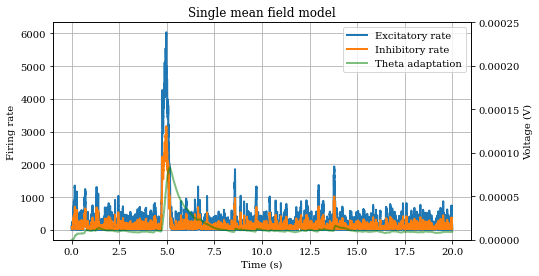

In [15]:
time, solution = run_single(model, gamma=80*uV)
plot_single(time, solution)

**Negative gamma** There are more peaks

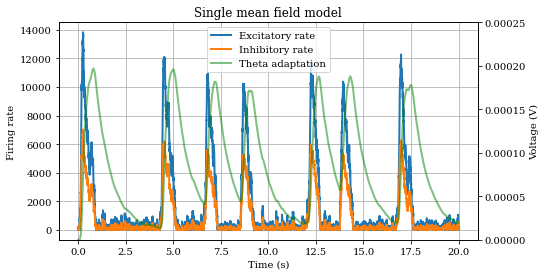

In [16]:
time, solution = run_single(model, gamma=-40*uV)
plot_single(time, solution)

**Positive (big) gamma** There are no peaks

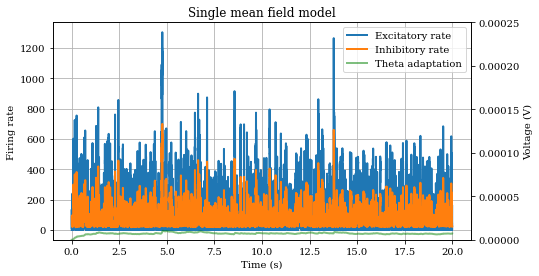

In [17]:
time, solution = run_single(model, gamma=300*uV)
plot_single(time, solution)

**Negative (big) gamma** One big peak and then saturation at 10k hz for excitatory and 5k hz for inhibitory

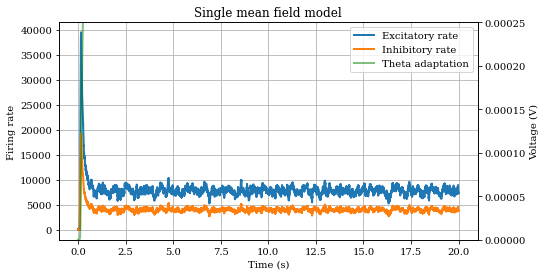

In [257]:
time, solution = run_single(model, gamma=-300*uV)
plot_single(time, solution)

### 3.Gamma-Frequency plot

Frequency detector with hysteresis

In [79]:
# Frequency detector with hysteresis
time, solution = run_single(model, gamma=-80*uV, tmax=40*s)

There are 17 peaks


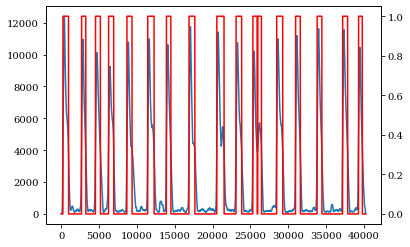

In [80]:
from collections import Counter

# 1.moving average
signal = solution[:,0]
signal = np.convolve(signal, np.ones(250))/250
# 2.threshold the signal
thr = signal>4000
# 3.count ascending jumps
values = thr.astype('int')
# 3.1 Computes the crossing 1: ascendent -1: descendent
difference = values[1:]-values[:-1]
# 3.2 Count the number of 1 (ascendent crossings)
peaks = Counter(difference)[1]

plt.plot(signal)
plt.twinx()
plt.plot(thr,c='r')

print(f"There are {peaks} peaks")

In [23]:
def count_peaks(signal, thr_val=4000, ones=250):
    # 1.moving average
    signal = signal
    signal = np.convolve(signal, np.ones(ones))/ones
    # 2.threshold the signal
    thr = signal>thr_val
    # 3.count ascending jumps
    values = thr.astype('int')
    # 3.1 Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # 3.2 Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    return peaks

Run experiments

In [71]:
# params
file_name = "gamma_results.txt"
time = 5*s
gammas = np.linspace(-200,150,15)*uV
seeds = np.linspace(1,100000,10,dtype=int)

f = open(file_name, 'w')
f.write("gamma,seed,frequency\n")

for gamma in gammas:
    current = 0
    for seed in seeds:
        _ , solution = run_single(model, seed=seed, gamma=gamma, tmax=time)
        frequency = count_peaks(solution[:,0])/time
        current += frequency
        f.write(f"{gamma} ,{seed} ,{frequency} \n")
        #print(f"Gamma = {gamma/uV:2f} uV - Seed = {seed} - Frequency = {frequency} Hz")
    print(f"Gamma = {gamma/uV:.2f} uV - Frequency (avg) = {current/10:.2f} Hz")

f.close()

Gamma = -200.00 uV - (average) Frequency = 0.20 Hz
Gamma = -175.00 uV - (average) Frequency = 0.40 Hz
Gamma = -150.00 uV - (average) Frequency = 0.60 Hz
Gamma = -125.00 uV - (average) Frequency = 0.80 Hz
Gamma = -100.00 uV - (average) Frequency = 0.60 Hz
Gamma = -75.00 uV - (average) Frequency = 0.60 Hz
Gamma = -50.00 uV - (average) Frequency = 0.40 Hz
Gamma = -25.00 uV - (average) Frequency = 0.40 Hz
Gamma = 0.00 uV - (average) Frequency = 0.40 Hz
Gamma = 25.00 uV - (average) Frequency = 0.40 Hz
Gamma = 50.00 uV - (average) Frequency = 0.20 Hz
Gamma = 75.00 uV - (average) Frequency = 0.20 Hz
Gamma = 100.00 uV - (average) Frequency = 0.00 Hz
Gamma = 125.00 uV - (average) Frequency = 0.00 Hz
Gamma = 150.00 uV - (average) Frequency = 0.00 Hz


Results analysis and plot

In [72]:
import pandas as pd

In [75]:
results = pd.read_csv(file_name)

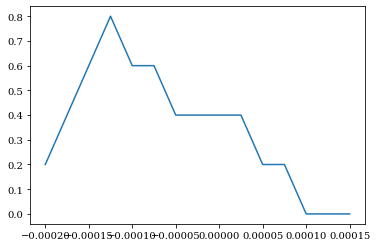

In [78]:
# quick visualization
plt.plot(results.gamma, results.frequency)

In [ ]:
# compute 95p confidence intervals

In [ ]:
# create plot

### 4.Two (ephaptically) coupled populations
Correlation coefficient and phase locking index

### 5.Two coupled populations with exogenous current